注解：
1. 好像是用sklearn的随机森林分类器做点云分类，并没有使用深度学习; 
3. 用[pyntcloud](https://github.com/daavoo/pyntcloud)提取了各种各样的特征； 
4. 17个类别,使用的数据集：[Paris-rue-Madame database](http://cmm.mines-paristech.fr/Projects/TerraMobilita/rueMadame_database.zip)，数据集是两个ply文件分别充当训练集和测试集，都是1千万个点，排除地面点和默认点，剩下90万个点   


2019.03.14 调通，测试集 Accuracy: 0.9174709432905417

![Point Cloud](.\docu\Paris-rue-Madame-database.png)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyntcloud import PyntCloud
from pyntcloud import scalar_fields
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors.kde import KernelDensity

In [5]:
def preProcessData(cld):
    ##Cacluate 50 neighbours for determining the geometrical features of each point
    neigh=cld.get_neighbors(k=50)
    neigh.shape
    
    #注释的特征暂未使用，因为计算量有点大，目前只有geometrical features使用
    '''
    #kde=KernelDensity(kernel='gaussian',bandwidth=0.2).fit(cld.points[['x','y','z']])
    #density=kde.score_samples(cld.points[['x','y','z']])
    #cld.points.add(density,axis=1)

    #vox=cld.add_structure("voxelgrid")
    #vox_x=cld.add_scalar_field("voxel_x",voxelgrid_id=vox)
    #vox_y=cld.add_scalar_field("voxel_y",voxelgrid_id=vox)
    #vox_n=cld.add_scalar_field("voxel_n",voxelgrid_id=vox)
    #vox_z=cld.add_scalar_field("voxel_z",voxelgrid_id=vox)
    #inc=cld.add_scalar_field("inclination_degrees")
    #ori=cld.add_scalar_field("orientation_degrees")
    '''
    eig=   cld.add_scalar_field("eigen_values",k_neighbors=neigh)
    ani=   cld.add_scalar_field("anisotropy",ev=eig)
    cur=   cld.add_scalar_field("curvature",ev=eig)
    eigent=cld.add_scalar_field("eigenentropy",ev=eig)
    su=    cld.add_scalar_field("eigen_sum",ev=eig)
    lin=   cld.add_scalar_field("linearity",ev=eig)
    om=    cld.add_scalar_field("omnivariance",ev=eig)
    pla=   cld.add_scalar_field("planarity",ev=eig)
    sph=   cld.add_scalar_field("sphericity",ev=eig)
    return cld

def pre1(cl):
    cl.points.rename(columns={
        "raw_classification":'class',
        "scan_angle_rank":'label',
        "flag_byte":'reflectance'},inplace=True)

    cl.points.drop(labels=["user_data","pt_src_id","gps_time"],inplace=True,axis=1)   
    return cl

# 训练集数据

In [6]:
## 加载训练集点云文件，加载后为pandas dataframe
cloud_train=PyntCloud.from_file("./data/yupont/cz_1-9_train.las")
print(cloud_train)

PyntCloud
1133888 points with 10 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 120.52012755394719, 63.5133796625337, 12.194775588378619
Other attributes:
	 las_header: <class 'laspy.header.HeaderManager'>



In [7]:
cloud_train.points.head()

,x,y,z,intensity,flag_byte,raw_classification,scan_angle_rank,user_data,pt_src_id,gps_time,red,green,blue
0,162.449997,1.480003,18.179998,175,9,6,0,1,2,458929.6574,36864,37888,37632
1,162.180000,1.459999,18.210001,135,9,6,0,1,2,458929.6684,36608,37888,37632
2,162.239998,1.540001,18.219999,144,9,6,0,1,2,458929.6684,40192,41984,40960
3,162.300003,1.620003,18.250002,190,9,6,0,1,2,458929.6684,39424,40192,39680
4,162.360001,1.699997,18.280001,150,9,6,0,1,2,458929.6684,35840,36864,36096


In [8]:
cloud_train = pre1(cloud_train)
cloud_train.points.head()

,x,y,z,intensity,reflectance,class,label,red,green,blue
0,162.449997,1.480003,18.179998,175,9,6,0,36864,37888,37632
1,162.180000,1.459999,18.210001,135,9,6,0,36608,37888,37632
2,162.239998,1.540001,18.219999,144,9,6,0,40192,41984,40960
3,162.300003,1.620003,18.250002,190,9,6,0,39424,40192,39680
4,162.360001,1.699997,18.280001,150,9,6,0,35840,36864,36096


In [9]:
cloud_train.points.describe()

,x,y,z,intensity,reflectance,class,label,red,green,blue
count,1.133888e+06,1.133888e+06,1.133888e+06,1.133888e+06,1.133888e+06,1.133888e+06,1133888.0,1.133888e+06,1.133888e+06,1.133888e+06
mean,1.205201e+02,6.351338e+01,1.219478e+01,1.847173e+02,1.414095e+01,4.658634e+00,0.0,2.232033e+04,2.874954e+04,2.153172e+04
std,3.623698e+01,2.795250e+01,7.395688e+00,4.492949e+01,5.202921e+00,2.570320e+00,0.0,9.245076e+03,8.566956e+03,8.599378e+03
min,-8.000185e-02,1.440002e+00,1.840860e-06,1.000000e+01,9.000000e+00,3.000000e+00,0.0,5.120000e+03,8.960000e+03,4.352000e+03
25%,9.845000e+01,4.257000e+01,7.789999e+00,1.540000e+02,9.000000e+00,4.000000e+00,0.0,1.612800e+04,2.304000e+04,1.612800e+04
50%,1.238700e+02,6.403000e+01,1.215000e+01,2.050000e+02,1.700000e+01,4.000000e+00,0.0,2.099200e+04,2.867200e+04,1.996800e+04
75%,1.486400e+02,8.586000e+01,1.545000e+01,2.170000e+02,1.800000e+01,5.000000e+00,0.0,2.636800e+04,3.353600e+04,2.432000e+04
max,1.754100e+02,1.165400e+02,6.818000e+01,3.530000e+02,2.600000e+01,2.000000e+01,0.0,6.528000e+04,6.528000e+04,6.528000e+04


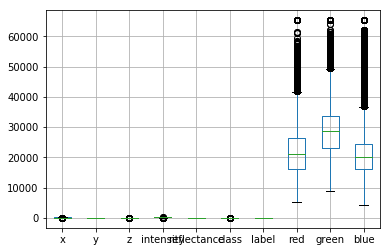

In [10]:
cloud_train.points.boxplot() # 图形化展示describe()

In [11]:
##Visualization of point cloud
# cloud_train.plot()

# 点云地物分类标准 
1默认点，2地面点，345-低中高，7低噪，8关键，9临建，10桥梁，
11铁路，12公路，13不河流，14湖泊，15变电站，16导线，17铁塔
18交跨上，19交跨下，20地线，21其他，22船舶汽车，23其他线路
24共塔其他线，25通航河流，26铁路承力索，27引流线，28绝缘子

In [12]:
# 排除地面点和默认点
cloud_train=PyntCloud(cloud_train.points[cloud_train.points["class"]!=2])
cloud_train=PyntCloud(cloud_train.points[cloud_train.points["class"]!=1])

In [13]:
#用open3做三维网格下采样 voxel grid downsampling
#open3d.voxelgrid_downsampling(cloud,voxel=0.5)
cloud_train.points["class"].value_counts()

5     429346
4     363239
3     277037
18     23418
8      18399
6       9436
17      6306
16      3331
19      1778
20      1598
Name: class, dtype: int64

In [14]:
# cloud_train.plot()

In [15]:
# 清理掉标签数据,防止数据泄露
cloud_train_target=cloud_train.points["class"]

cloud_train.points.drop(labels=["class"],inplace=True,axis=1)

cloud_train_pp = preProcessData(cloud_train)
cloud_train_pp.points.drop(labels=["label"],inplace=True,axis=1)
cloud_train_pp.points.drop(labels=["reflectance"],inplace=True,axis=1)
cloud_train_pp.points.head()
#cloud_train_pp.points.to_csv("features_calculated_train.csv",index=False)

,x,y,z,intensity,red,green,blue,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
0,162.449997,1.480003,18.179998,175,36864,37888,37632,0.127866,0.043123,0.000088,0.999309,0.000516,0.399382,0.171077,0.662748,0.007868,0.336562,0.000691
1,162.180000,1.459999,18.210001,135,36608,37888,37632,0.135605,0.039848,0.000102,0.999251,0.000579,0.400292,0.175554,0.706145,0.008187,0.293106,0.000749
2,162.239998,1.540001,18.219999,144,40192,41984,40960,0.115700,0.044413,0.000076,0.999340,0.000477,0.388571,0.160189,0.616140,0.007320,0.383200,0.000660
3,162.300003,1.620003,18.250002,190,39424,40192,39680,0.107751,0.047999,0.000087,0.999192,0.000559,0.386627,0.155836,0.554539,0.007665,0.444653,0.000808
4,162.360001,1.699997,18.280001,150,35840,36864,36096,0.089657,0.057329,0.000096,0.998927,0.000654,0.381020,0.147081,0.360576,0.007907,0.638352,0.001073


In [16]:
cloud_train_pp.points.describe()
# sklearn的随机森林分类器
rfc = RandomForestClassifier()

In [17]:
rfc.fit(cloud_train_pp.points,cloud_train_target)

/home/huhongjun/anaconda2/envs/urban/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
# 预测训练数据
prediction=rfc.predict(cloud_train.points)
print("Accuracy:",accuracy_score(cloud_train_target,prediction))

Accuracy: 0.9969282680476379


In [20]:
import pickle
filename = "random_forest.sav"
pickle.dump(rfc,open(filename,'wb'))

rfc_model = pickle.load(open("random_forest.sav","rb"))

# Test Set Evaluation

In [21]:
import pickle
rfc_model = pickle.load(open("random_forest.sav","rb"))

In [22]:
# 测试集数据

cloud_test=PyntCloud.from_file("./data/yupont/cz_1-9_test.las")
print(cloud_test)

#cloud_test.plot()

PyntCloud
554065 points with 10 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 64.32115136806438, 87.44790360439872, 2.684565871869543
Other attributes:
	 las_header: <class 'laspy.header.HeaderManager'>



In [23]:
cloud_test.points.head()


,x,y,z,intensity,flag_byte,raw_classification,scan_angle_rank,user_data,pt_src_id,gps_time,red,green,blue
0,-0.079956,149.840027,13.080000,189,17,16,0,1,6,459322.884809,65280,65280,65280
1,-0.010010,149.700012,13.060000,48,17,16,0,1,6,459322.895795,65280,65280,65280
2,0.060059,149.710022,13.089998,138,17,16,0,1,6,459322.906598,65280,65280,65280
3,0.180054,149.520020,13.080000,94,17,16,0,1,6,459322.917615,65280,65280,65280
4,0.250000,149.489990,13.089998,175,17,16,0,1,6,459322.928601,65280,65280,65280


In [24]:
cloud_test = pre1(cloud_test)

cloud_test.points.head()

,x,y,z,intensity,reflectance,class,label,red,green,blue
0,-0.079956,149.840027,13.080000,189,17,16,0,65280,65280,65280
1,-0.010010,149.700012,13.060000,48,17,16,0,65280,65280,65280
2,0.060059,149.710022,13.089998,138,17,16,0,65280,65280,65280
3,0.180054,149.520020,13.080000,94,17,16,0,65280,65280,65280
4,0.250000,149.489990,13.089998,175,17,16,0,65280,65280,65280


In [25]:
cloud_test.points["class"].value_counts()

3     287411
4     113675
14     96811
5      38538
8      12968
16      3210
20      1452
Name: class, dtype: int64

测试集数据同样需要做数据预处理，提取相关特征。

In [26]:
#Downsampling not required as the dataset is already cleaned
#voxel grid downsampling will be done here
#open3d.voxelgrid_downsampling(cloud1,voxel=0.5)
#p linkage segmentation and shape distribution histogram

In [27]:
#cloud_test=PyntCloud(cloud_test.points[cloud_test.points["class"]!=2])
#cloud_test=PyntCloud(cloud_test.points[cloud_test.points["class"]!=1])

cloud_test_target=cloud_test.points["class"]
cloud_test.points.drop(labels=["class"],inplace=True,axis=1)

cloud_test_pp = preProcessData(cloud_test)
cloud_test_pp.points.drop(labels=["label"],inplace=True,axis=1)
cloud_test_pp.points.drop(labels=["reflectance"],inplace=True,axis=1)  

In [28]:
cloud_test_pp.points.head()

,x,y,z,intensity,red,green,blue,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
0,-0.079956,149.840027,13.080000,189,65280,65280,65280,3.382024,0.0004,0.000034,0.99999,0.00001,-4.117434,3.382458,0.999882,0.003575,0.000108,0.00001
1,-0.010010,149.700012,13.060000,48,65280,65280,65280,3.382024,0.0004,0.000034,0.99999,0.00001,-4.117434,3.382458,0.999882,0.003575,0.000108,0.00001
2,0.060059,149.710022,13.089998,138,65280,65280,65280,3.382024,0.0004,0.000034,0.99999,0.00001,-4.117434,3.382458,0.999882,0.003575,0.000108,0.00001
3,0.180054,149.520020,13.080000,94,65280,65280,65280,3.382024,0.0004,0.000034,0.99999,0.00001,-4.117434,3.382458,0.999882,0.003575,0.000108,0.00001
4,0.250000,149.489990,13.089998,175,65280,65280,65280,3.382024,0.0004,0.000034,0.99999,0.00001,-4.117434,3.382458,0.999882,0.003575,0.000108,0.00001


In [29]:
prediction_test=rfc.predict(cloud_test_pp.points)
print("Accuracy:",accuracy_score(cloud_test_target,prediction_test))

Accuracy: 0.5800492721973054
